In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
def f(x):
  return 3*x**2-4*x+5
f(3.0)

20.0

In [ ]:
xs=np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
yx=f(xs)


In [ ]:
yx

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

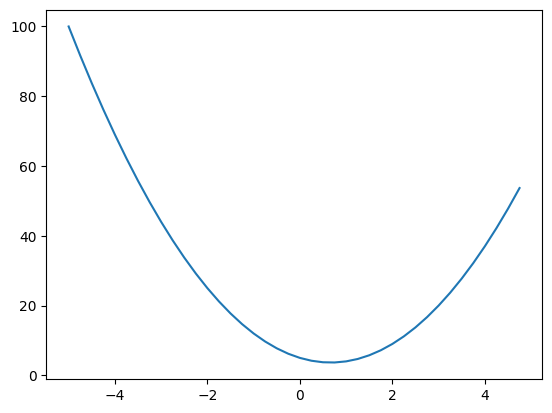

In [ ]:
plt.plot(xs,yx)

In [ ]:
h=0.0000001
x=3.0
(f(x+h)-f(x))/h #at 3 the slope is 14

14.000000305713911

In [ ]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [ ]:
h=.0001
a=2.0
b=-3.0
c=10.0
d1=a*b+c
a+=h
d2=a*b+c
print('d1 ',d1)
print('d2 ',d2)
print('slope:' ,(d2-d1)/h)


d1  4.0
d2  3.999699999999999
slope: -3.000000000010772


# Manual Back Propagation


In [ ]:
d._prev
d._op

'+'

In [ ]:
from graphviz import Digraph
def Trace(root):
  nodes,edges=set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges

def draw_dot(root):
  dot=Digraph(format='svg',graph_attr={'rankdir':'LR'})
  nodes,edges=Trace(root)
  for n in nodes:
    uid=str(id(n))
    dot.node(name=uid,label='{%s|data %.4f|grad %.4f}'%(n.label,n.data,n.grad),shape='record')
    if n._op:
      dot.node(name=uid+n._op,label=n._op)
      dot.edge(uid+n._op,uid)
  for n1,n2 in edges:
    dot.edge(str(id(n1)),str(id(n2))+n2._op)
  return dot

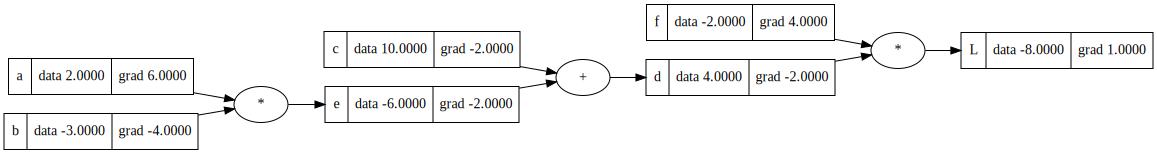

In [ ]:
draw_dot(L)

In [ ]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad


e=a*b
d=e+c
L=d*f

print(L.data)

4.7063039999999985


In [ ]:
L.grad=1.0

In [ ]:
f.grad=4.0
d.grad=-2.0

In [ ]:
c.grad=-2.0 #chain rule : dl/dd * dd/dc ( -2.0* 1.0)
e.grad=-2.0

In [ ]:
a.grad=-2.0 * -3.0 #dl/da= dl/de * de/da
b.grad=-2.0 * 2.0

In [ ]:
def lol():
  h=0.001

  a=Value(2.0,label='a')
  b=Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b
  e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0,label='f')
  L=d*f; L.label='L'
  L1=L.data

  a=Value(2.0,label='a')
  b=Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b
  e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0,label='f')
  L=d*f; L.label='L'
  L2=L.data
  #to check derivate increment the variable by h

  print((L2-L1)/h)
lol()

0.0


In [ ]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data=data
    self._prev=set(_children)
    self._op=_op
    self.label=label
    self.grad=0.0
    self._backward=lambda:None
  def __repr__(self):
    return f'Value : (data: {self.data})'

  def __add__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data+other.data,(self,other),'+')
    def _backward():
      self.grad+=1.0*out.grad  #accumulate the gradient in case of multiple variables
      other.grad+=1.0*out.grad
    out._backward=_backward
    return out

  def __mul__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data*other.data,(self,other),'*')
    def _backward():
      self.grad+=other.data*out.grad
      other.grad+=self.data*out.grad
    out._backward=_backward
    return out
  def __rmul__(self,other):#other * self
    return self*other

  def __truediv__(self,other):
    return self * other**-1
  def __neg__(self):
    return self * -1
  def __sub__(self,other):
    return self+(-other)

  def __pow__(self,other):
    assert isinstance(other, (int,float))
    out=Value(self.data**other,(self,),f'**{other}')
    def _backward():
      self.grad+=(other*self.data**(other-1))*out.grad
    out._backward=_backward
    return out

  def tanh(self):  #activation function
    x=self.data
    t=(math.exp(x*2)-1)/(math.exp(x*2)+1)
    out=Value(t,(self,),'tanh')
    def _backward():
      self.grad+=(1-t**2)*out.grad
    out._backward=_backward
    return out

  def exp(self):
    x=self.data
    out=Value(math.exp(x),(self,),'exp')
    def _backward():
      self.grad+=out.data*out.grad
    out._backward=_backward
    return out


  def backward(self):
    topo=[]
    visited=set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1.0
    for node in reversed(topo):
      node._backward()


# a=Value(2.0,label='a')
# b=Value(-3.0,label='b')
# c=Value(10.0,label='c')
# e=a*b
# e.label='e'
# d=e+c; d.label='d'
# f=Value(-2.0,label='f')
# L=d*f; L.label='L'
# L

In [ ]:
a=Value(2.0)
a.exp()

Value : (data: 7.38905609893065)

# Back Propagation through neuron

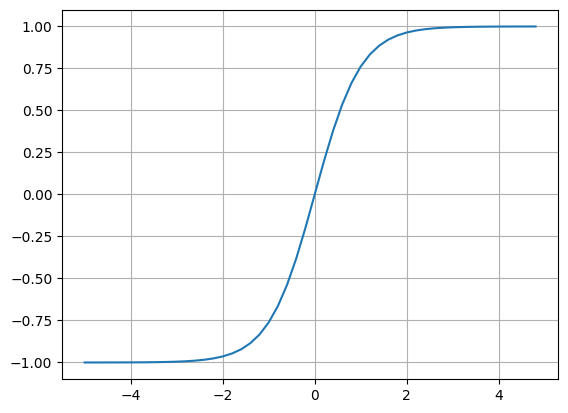

In [ ]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [ ]:
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')

w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#biases
b=Value(6.8813735870195432,label='b')

#x1w1 + x2w2 + b
x1w1=x1*w1; x1w1.label='x1w1'
x2w2=x2*w2; x2w2.label='x2w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
#o=n.tanh()
e=(2*n).exp()
o=(e-1)/(e+1)
o.label='o'
o.backward()

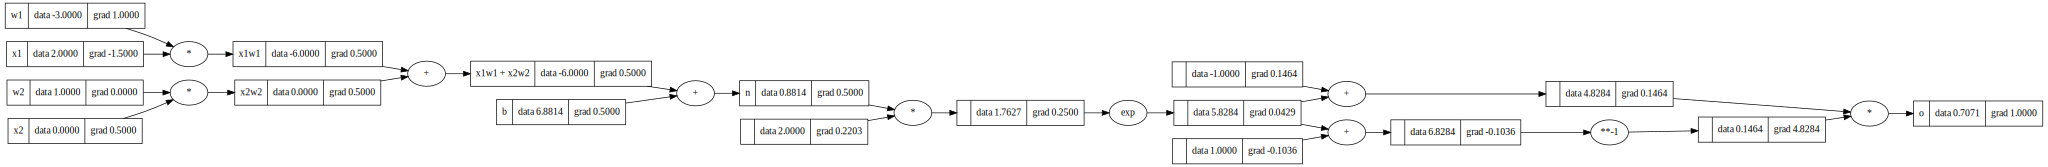

In [ ]:
draw_dot(o)

In [ ]:
#directly calling backward for all
# o.grad=1.0
# topo=[]
# visited=set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#   node._backward()
#to be put in main body to hide the function



# Neural Net (MLP)

In [ ]:
import torch

In [ ]:
x1=torch.Tensor([2.0]).double() ; x1.requires_grad=True
w1=torch.Tensor([-3.0]).double() ; w1.requires_grad=True
x2=torch.Tensor([0.0]).double() ; x2.requires_grad=True
w2=torch.Tensor([1.0]).double() ; w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]).double() ; b.requires_grad=True
n=x1*w1 + x2*w2 + b
o=torch.tanh(n)
print(o.data.item())
o.backward()
print('----')
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('x2',x2.grad.item())
print('w2',w2.grad.item())



0.7071066904050358
----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [ ]:
import random
class Neuron:
  def __init__(self,nin):
    self.w=[Value(random.uniform(-1,1))for _ in range (nin)]
    self.b=Value(random.uniform(-1,1))
  def __call__(self,x):
    act=sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
    out=act.tanh()
    return out
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]
  def __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params=[]
    # for neuron in self.neurons:
    #   ps=neuron.parameters
    #   params.extend(ps)
    # return params

class MLP:
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
  def __call__(self,x):
    for layers in self.layers:
      x=layers(x)
    return x
  def paramters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [ ]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value : (data: 0.7931476933769102)

In [ ]:
len(n.paramters())

41

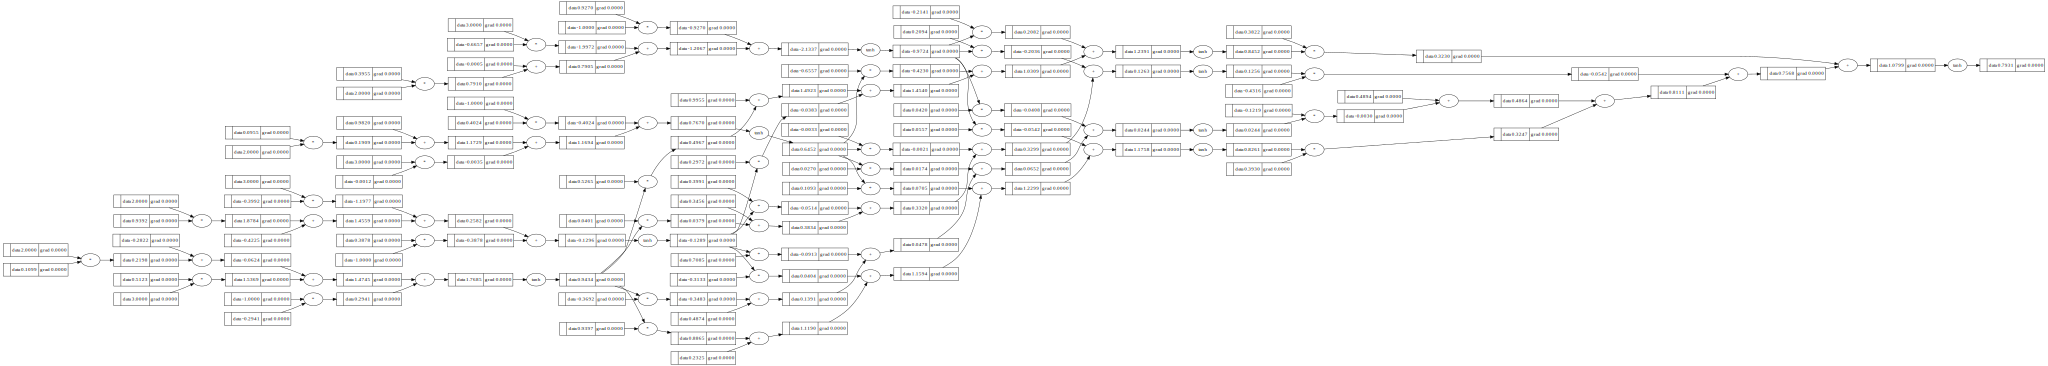

In [ ]:
draw_dot(n(x))

In [ ]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys=[1.0,-1.0,-1.0,1.0]
ypred=[n(x) for x in xs]
ypred

[Value : (data: 0.7931476933769102),
 Value : (data: -0.01918243850636424),
 Value : (data: 0.4569543933658887),
 Value : (data: 0.7652319626126689)]

In [ ]:
#GRADIENT DECENT

for k in range(20):
  #forward pass
  ypred=[n(x) for x in xs]
  loss= sum(((yout-ygt)**2 for ygt,yout in zip(ys,ypred)),Value(0.0))
  #backward pass
  for p in n.paramters():
    p.grad=0.0
  loss.backward()
  #update
  for p in n.paramters():
    p.data+= -0.05*p.grad
  print(k,loss.data)

0 0.030440227018733557
1 0.0286602857206213
2 0.027065138122020313
3 0.025628163535323788
4 0.02432754394459747
5 0.023145238374964
6 0.022066207466848134
7 0.021077820208328955
8 0.020169395048522703
9 0.019331841359089275
10 0.01855737667656314
11 0.017839301771512092
12 0.017171820272916305
13 0.01654989293264561
14 0.015969119048795215
15 0.015425639350582073
16 0.014916055968272944
17 0.014437366098726116
18 0.0139869067214311
19 0.013562308285849133


In [ ]:
ypred

[Value : (data: 0.9653010231572909),
 Value : (data: -0.9698832999425226),
 Value : (data: -0.9186470398311519),
 Value : (data: 0.930480437707563)]

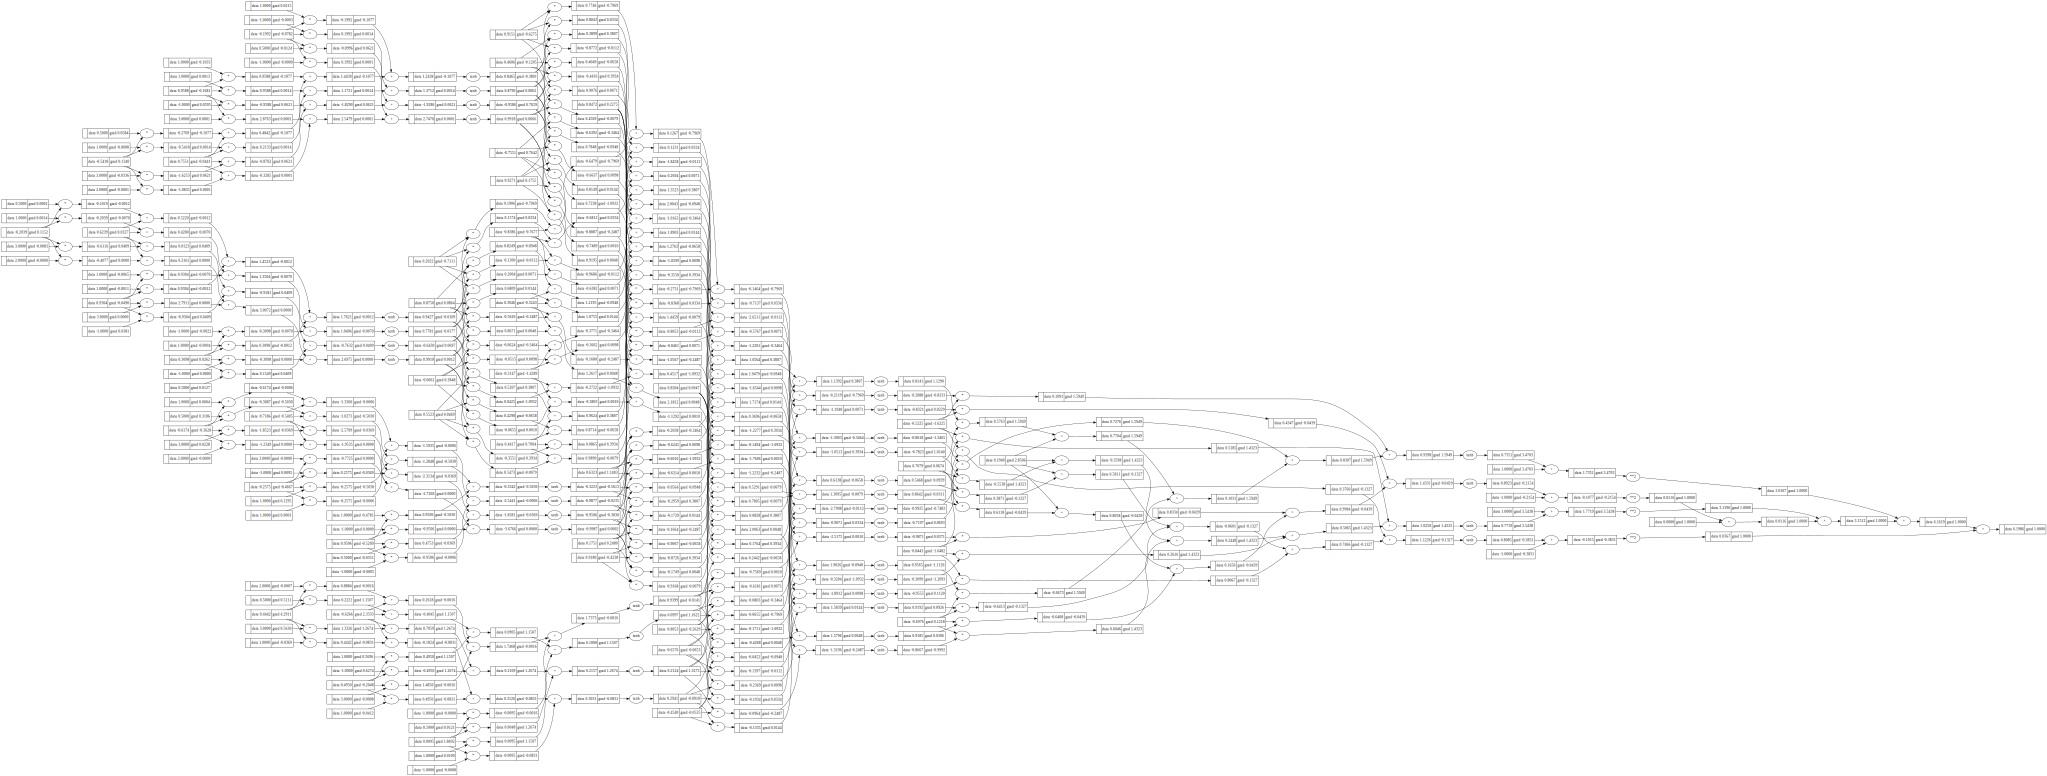

In [ ]:
draw_dot(loss)